In [1]:
import numpy as np
import tqdm
from multiprocessing import Pool
from contextlib import closing
import sys
sys.path.append("..")

from phenixml.fragments.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.models.nn_fragments import FragmentKNN
from phenixml.visualization.fragment_display import FragmentDisplay
from phenixml.visualization.plotting import plot_geom_eval
display = FragmentDisplay()


from phenixml.utils.mp_utils import pool_with_progress
import matplotlib.pyplot as plt

In [15]:
# Load molecule containers
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:32<00:00, 489.52it/s]


In [16]:
# Fragment the molecules
fragmenter = AngleFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [00:24<00:00, 659.37it/s]


In [17]:
# Featurize the fragments
featurizer = MorganFeaturizer()
features = featurizer(fragments,nproc=32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550515/550515 [08:35<00:00, 1068.60it/s]


In [18]:
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550515/550515 [07:25<00:00, 1236.86it/s]


In [19]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [20]:
%%time
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train,metric="rogerstanimoto")

CPU times: user 1h 18min 41s, sys: 4min, total: 1h 22min 41s
Wall time: 3min 29s


In [21]:
# choose a single query to illustrate kNN search
query_idx = 101
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

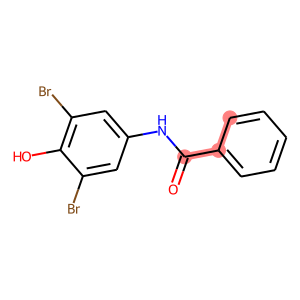

In [22]:
display(query_frag,hideHs=True,size=(300,300))

In [ ]:
display(nbrs,nmax=3)

In [ ]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [ ]:
nbr_mean_label = nbr_labels.mean(axis=1)

In [ ]:
plot_geom_eval(np.degrees(labels_test),np.degrees(nbr_mean_label),mode="angle")

In [ ]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

## MLP Regression

In [16]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [17]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=1)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [18]:
# set up tensors
gpuid = 1
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

if gpuid is not None:
  feat_train_t = feat_train_t.to("cuda:"+str(gpuid))
  labels_train_t = labels_train_t.to("cuda:"+str(gpuid))
  model = model.to("cuda:"+str(gpuid))

In [19]:
# train
epoch_losses = []
n_epoch=3000


for epoch in tqdm.tqdm(range(n_epoch)):
    
  pred = model(feat_train_t)
  loss = metric(pred,labels_train_t)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:28<00:00, 11.16it/s]


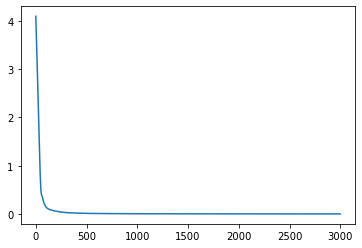

In [20]:
plt.plot(epoch_losses)

In [21]:
if gpuid is not None:
  model = model.to("cpu")
pred = model(feat_test_t)

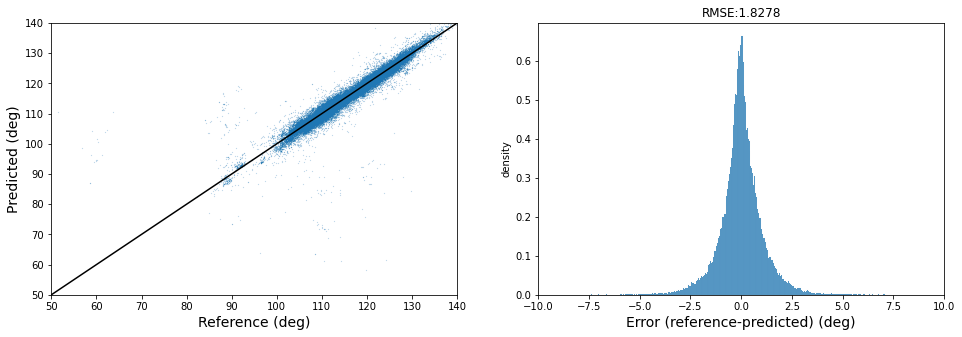

In [22]:
plot_geom_eval(np.degrees(labels_test),np.degrees(to_np(pred)),mode="angle")

In [23]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15815
Mols better than cutoff: 15604
Mols worse than cutoff: 211
